#Job Level Classification Using NLP and Machine Learning

 Model kết hợp giữa NLP và Machine Learning với mục đích phân loại job level

In [219]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler, SMOTEN
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile,chi2
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [220]:
df = pd.read_excel(r'/content/final_project.ods',dtype= str)
df.head(3)

,title,location,description,function,industry,career_level
0,Technical Professional Lead - Process,"Houston, TX","Responsible for the study, design, and specifi...",production_manufacturing,Machinery and Industrial Facilities Engineering,senior_specialist_or_project_manager
1,Cnslt - Systems Eng- Midrange 1,"Seattle, WA","Participates in design, development and implem...",information_technology_telecommunications,Financial Services,senior_specialist_or_project_manager
2,SharePoint Developers and Solution Architects,"Dallas, TX",We are currently in need of Developers who can...,consulting,IT Consulting,senior_specialist_or_project_manager


# Clearning Data

In [221]:
df.shape

(8074, 6)

In [222]:
df.dtypes

,0
title,object
location,object
description,object
function,object
industry,object
career_level,object


In [223]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [224]:
df.isnull().sum()
df.dropna(inplace=True)
df.shape

(8052, 6)

In [225]:
df.head()

,title,location,description,function,industry,career_level
0,Technical Professional Lead - Process,"Houston, TX","Responsible for the study, design, and specifi...",production_manufacturing,Machinery and Industrial Facilities Engineering,senior_specialist_or_project_manager
1,Cnslt - Systems Eng- Midrange 1,"Seattle, WA","Participates in design, development and implem...",information_technology_telecommunications,Financial Services,senior_specialist_or_project_manager
2,SharePoint Developers and Solution Architects,"Dallas, TX",We are currently in need of Developers who can...,consulting,IT Consulting,senior_specialist_or_project_manager
3,Business Information Services - Strategic Acco...,North Carolina,Experian is seeking an experienced Account Exe...,sales,"Security, Risk, Restructuring Consulting",senior_specialist_or_project_manager
4,Strategic Development Director (procurement),"Austin, TX",Â Want to join a world-class global procuremen...,procurement_materials_logistics,Information Technology,bereichsleiter


vì ở cột location có dạng 'tên bang, tiên viết tắt' hoặc 'tên bang'. ta cần extract thành ra tên viết tắt( nếu có), nếu không có, giữ nguyên tên bang.

In [226]:
# created function
def extraction(location):
    results= re.findall("\,\ [A-Z]{2}$",location)
    if len(results) != 0:
        return results[0][2:]
    else:
        return location

In [227]:
df['location'] = df['location'].apply(extraction)

In [228]:
df.nunique()

,0
title,6789
location,97
description,7973
function,19
industry,352
career_level,6


# Data visualization

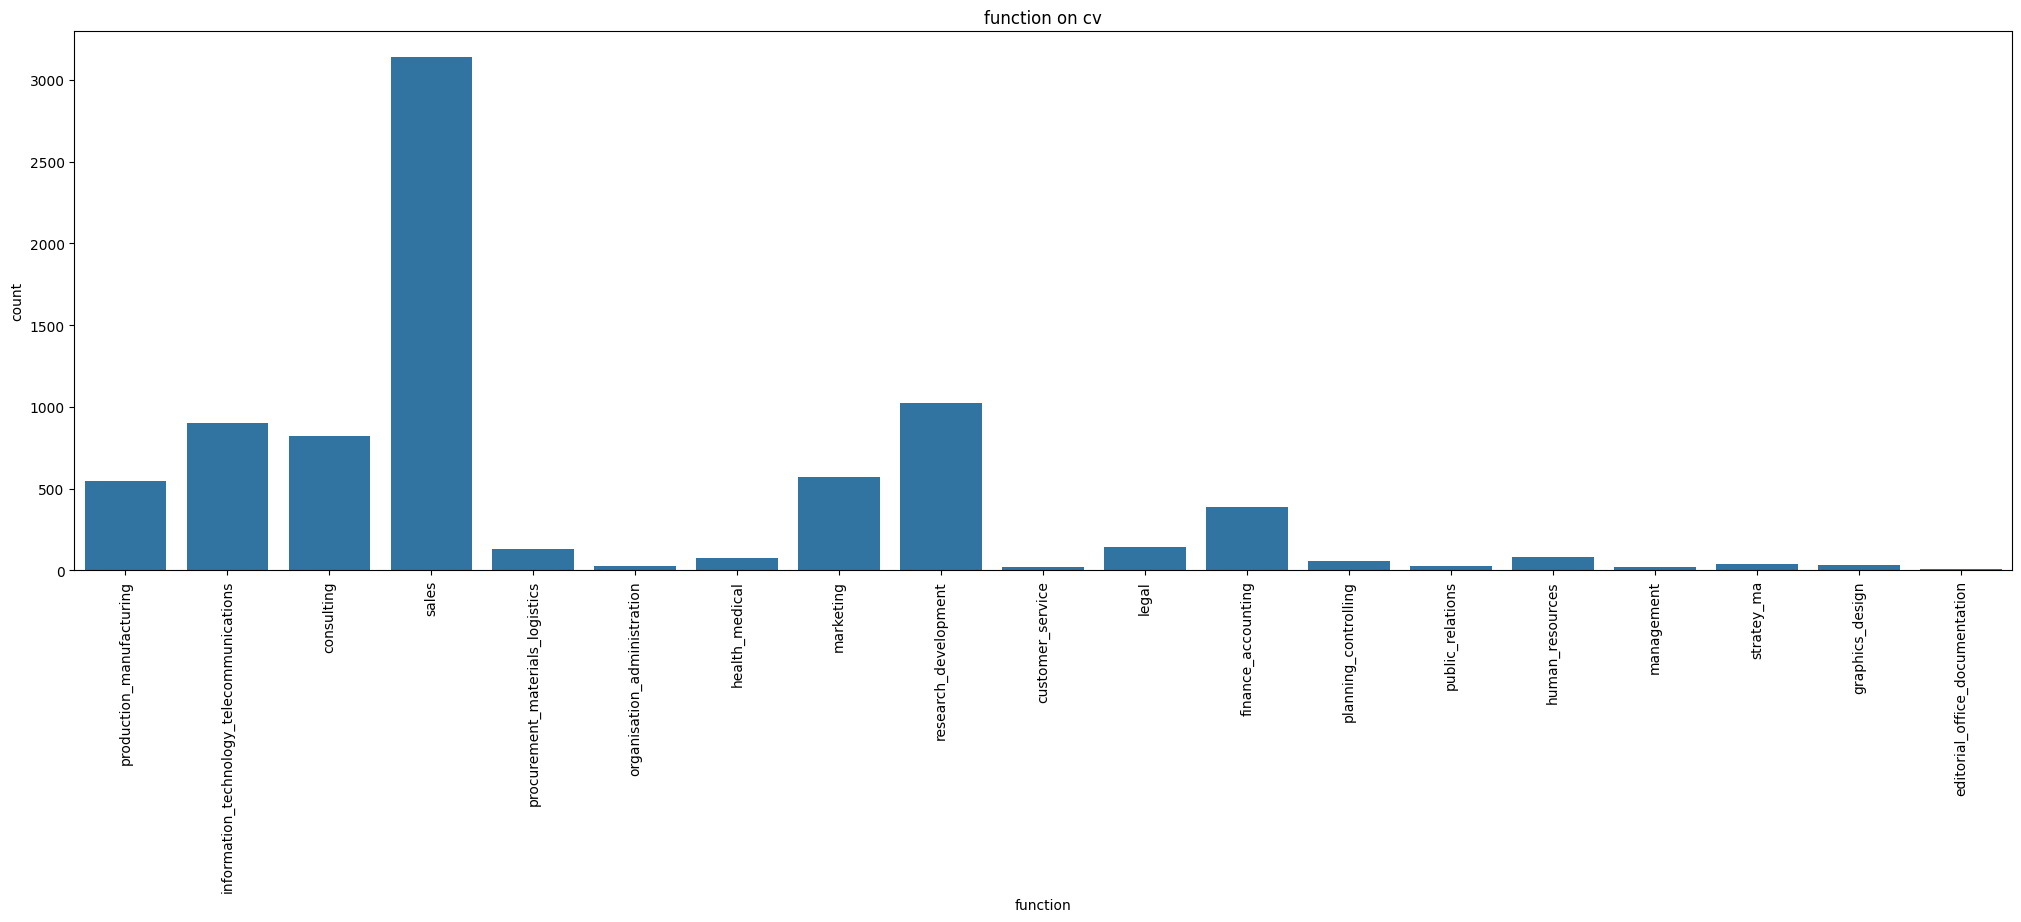

In [229]:
# biểu đồ số lượng cv ứng tuyển của từng chức năng khác nhau
fig, ax = plt.subplots(figsize=(25,7))
fig.subplots_adjust(hspace=0.9)
sns.countplot(data=df, x ='function').set_title('function on cv')
ax.xaxis.set_tick_params(rotation=90)

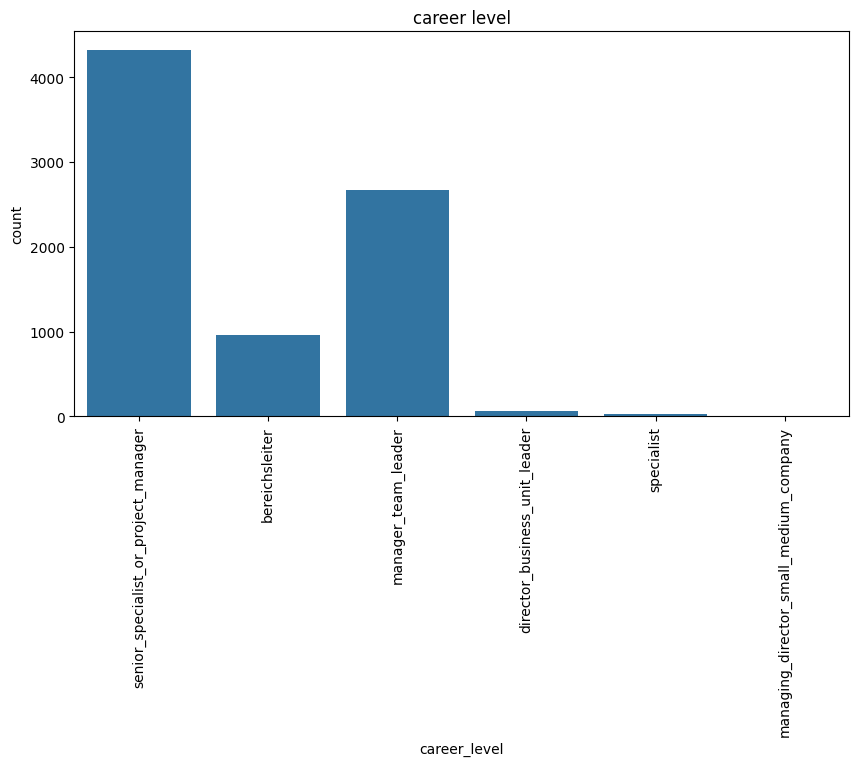

In [230]:
# biểu đồ số lượng các level, kiểm tra  mức độ lệch của balels
fig, ax = plt.subplots(figsize=(10,5))
fig.subplots_adjust(hspace=0.9)
sns.countplot(x= df['career_level']).set_title('career level')
ax.xaxis.set_tick_params(rotation=90)

In [231]:

df['career_level'].value_counts()

,count
career_level,
senior_specialist_or_project_manager,4323
manager_team_leader,2667
bereichsleiter,958
director_business_unit_leader,70
specialist,30
managing_director_small_medium_company,4


In [232]:
x = df.iloc[:,:-1]
target = 'career_level'
y = df[target]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state= 42,stratify= y)

 ý tưởng ở đây là tiếng hành sử dụng smoten với số lượng nhỏ để giảm khả năng over fitting, sau đó thêm Randomoversampling để giảm lệch

In [233]:
y_train.value_counts()

,count
career_level,
senior_specialist_or_project_manager,3458
manager_team_leader,2134
bereichsleiter,766
director_business_unit_leader,56
specialist,24
managing_director_small_medium_company,3


In [234]:
over_sample = SMOTEN(random_state=0, k_neighbors=2, sampling_strategy={
    "director_business_unit_leader": 500,
    "specialist": 500,
    "managing_director_small_medium_company": 500
})
x_train, y_train = over_sample.fit_resample(x_train,y_train)
y_train.value_counts()

,count
career_level,
senior_specialist_or_project_manager,3458
manager_team_leader,2134
bereichsleiter,766
director_business_unit_leader,500
specialist,500
managing_director_small_medium_company,500


In [235]:
over_sample_R = RandomOverSampler()
x_train,y_train = over_sample_R.fit_resample(x_train,y_train)
y_train.value_counts()

,count
career_level,
senior_specialist_or_project_manager,3458
manager_team_leader,3458
bereichsleiter,3458
director_business_unit_leader,3458
specialist,3458
managing_director_small_medium_company,3458


#mã hóa

In [236]:
preprocessor = ColumnTransformer(transformers=[
    ("title_ft", TfidfVectorizer(stop_words="english", ngram_range=(1, 1)), "title"),
    ("location_ft", OneHotEncoder(handle_unknown="ignore"), ["location"]),
    ("des_ft", TfidfVectorizer(stop_words="english", ngram_range=(1, 2), min_df=0.01, max_df=0.95), "description"),
    ("function_ft", OneHotEncoder(handle_unknown="ignore"), ["function"]),
    ("industry_ft", TfidfVectorizer(stop_words="english", ngram_range=(1, 1)), "industry")
])

# thử các mô hình phân loại

In [237]:

pipline_R = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_selector", SelectPercentile(chi2, percentile=5)),
    ("model", RandomForestClassifier(criterion='entropy',n_estimators=300,random_state= 42))])

In [238]:
pipline_R.fit(x_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('title_ft',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'title'),
                                                 ('location_ft',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['location']),
                                                 ('des_ft',
                                                  TfidfVectorizer(max_df=0.95,
                                                                  min_df=0.01,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'description'),
                                                 ('function_ft',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['function']),
                                                 ('industry_ft',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'industry')])),
                ('feature_selector',
                 SelectPercentile(percentile=5,
                                  score_func=<function chi2 at 0x7f9f670c3b00>)),
                ('model',
                 RandomForestClassifier(criterion='entropy', n_estimators=300,
                                        random_state=42))])

In [239]:
results = pipline_R.predict(x_test)


#Randomforest

{'model__criterion': 'entropy', 'model__n_estimators': 400}

                              accuracy                           0.74      1611
                             macro avg       0.45      0.39      0.39      1611
                          weighted avg       0.72      0.79      0.72      1611

#SVC

                              accuracy                           0.69      1611
                             macro avg       0.56      0.61      0.57      1611
                          weighted avg       0.70      0.69      0.69      1611

#LogisticRegression

                              accuracy                           0.65      1611
                             macro avg       0.40      0.50      0.43      1611
                          weighted avg       0.68      0.65      0.66      1611


#MultinomialNB

                              accuracy                           0.62      1611
                             macro avg       0.33      0.51      0.36      1611
                          weighted avg       0.65      0.62      0.63      1611


chỉ số quan tâm của project này là recall_weight, vì bộ dữ liệu và model phục vụ cho việc kiểm tra xem level ứng viên apply, với dữ liệu đầu vào là text, tăng cường khả năng tìm kiếm được nhiều ứng viên nhất có thể thông qua cv.
thông các mô hình thì Randomforest là mô hình tối ưu nhất

# DEMO

In [240]:
# dữ liệu đầu vào để demo
du_lieu_thuc= [['Technical Sales Representative - Oil & Gas Sector','Calgary','Contribute intensively &amp; directly to the market development strategy &amp; activities for the Oil &amp; Gas sector as well as key Industrial segments within Calgary region specially for new clients.To develop &amp; maintain regular and close contact with all key Oil &amp; Gas customers within the Calgary region.To penetrate the Oil &amp; Gas market and maximize sales opportunities through the development of an effective sales strategy and local marketing programs for all current and future AII range of products.To ensure registrations of Atlas Copco products and the company with all EPC contractors in the assigned territory.To visit clients regularly for market development, lead creation, technical discussion, negotiation and progress meetings.To ensure that the customers, EPC Contractors and consultants have up to date sales and technical information by maintaining regular contact in the market place.review customers RFQ and prepare professional quotations in line with Customerâ€™s requirement incl. identifying/assessing comments and exceptions to the RFQ for Oil and Gas market as well as for key account clients incl. OEM for all Industrial Air product range.Explore the market for new business opportunities within the Oil &amp; Gas customers &amp; consultants as well as in other key Industrial market segments in Calgary.Interact/Co-ordinate with the after-market department on behalf of clients where required to ensure Customer Satisfaction.Effective introduction of new products like N2 / O2 Generators, Gas Purification &amp; BiogasUpgrading Systems as well as Vacuum pumps into the Oil &amp; Gas sector including Refineries / Petrochemical complex and key Industrial clients.To work very closely with the BLM, Marketing team, proposal and Contract team to achieve the set targets/results and ensure timely completion of contracts to customer expectations.Conduct a detailed survey on all customers and competition.Act as a Compressor Technique ambassador in the market place and work closely with oil free air (AIF) divisionâ€™s Oil &amp; gas counterpart with coordinated actions where necessary including prospection activities in order to build efficiency while providing the best customer support.To undertake ad hoc projects as required by the BLM and the company.Â Mission:Your Mission is to maximize the sales of the custom designed and engineered compressed air packages across the whole Industrial Air division product range incl. N2 &amp; O2 generators for Oil &amp; Gas industry in Calgary region.  We are looking for a qualified Engineering graduate to take up this challenge and contribute to the growth of the Oil &amp; Gas business by developing, promoting and maintaining close contacts with all EPC Contractors and consultants within Calgary area. In addition to the above, the responsibility will also include sales and market development of standard products into the key Industrial segments, key accounts and OEMâ€™S within Calgary market.Â Experience requirements:Â Proven experience in selling industrial equipment and must have strong ability to close orders.Good understanding and experience on sales territory management and itâ€™s actual implementation.Experience in selling of Compressed air products is a plus.Broad experience in dealing with the Oil and Gas sector.Minimum 5 years experience in selling engineered solutions.Â Knowledge:Â An engineering degree (preferable) or equivalent gained from experience Knowledge of the compressed air industry (especially industrial air compressors) and its applications.Â Educational requirements:Â University degree in Engineering, Business/Marketing or similar through experience.Â human_resourcesity requirements:Â A proven self-starter &amp; a team player who requires minimum supervision and can coordinate efforts to achieve sales targets.Excellent communication skills with the ability to make technical presentations.Computer literate (Lotus Notes, Microsoft Office, etc.)Good understanding and use of company rules and policies (applicable to the sales process)Self motivated &amp; Excellent interhuman_resources skills.Â Additional information:Please take note that Foreign nationals are allowed to work temporarily in Canada if they have skills that are in demand in the Canadian labor market, but Canadian employers must first try to recruit Canadian citizens and permanent residents to fill available jobs. If no Canadian citizens or permanent residents have the necessary skills for a particular job, the employer may hire a foreign national.  If you are a Non-Canadian citizen looking to immigrate and find a job in Canada you must apply for residence through the Skilled Worker Program or post your profile on www.icanzoom.com, the leading job search website in Canada for international jobseekers.Â Country and city description:This position will ideally be based in Calgary, Alberta.Â Company presentation:Atlas Copco Compressors Canada is the Canadian customer centre within Compressor Technique responsible for marketing, sales and aftermarket for Industrial and Oil-Free divisions. The company with its 140 employees has a long-standing record of delivering good results in a very competitive market. The head office is based in Dollard-des-Ormeaux, Quebec and is supported by five (5) regional Sales and Aftermarket Customer Support Centres in Toronto, ON; Kitchener, ON; Calgary, AB; Edmonton, AB and Vancouver, BC.Â  Avancerad sÃ¶kning Hur du ansÃ¶ker Prenumerera pÃ¥ nya jobb FÃ¶r studenterMer information om...ProdukterServiceAtlas Copco i SverigeGruppenFÃ¶retagets ansvarKarriÃ¤rNyheterInvesterareFÃ¶lj oss pÃ¥ TwitterGÃ¶r oss sÃ¤llskap pÃ¥ Facebook SÃ¶k produkterAsfaltlÃ¤ggningsutrustningBearbetande verktygBelysningsmasterBetongutrustningBorraggregat och bergborrmaskinerBorrverktygDemoleringsutrustningExpandrarFrÃ¤sningsutrustningGeneratorerInjekteringsutrustningLast- och transportutrustningLÃ¶sningar fÃ¶r energiÃ¥tervinning Luft- och gasbehandlingLuft- och gaskompressorerLuftmotorerLyftblock och lÃ¶pvagnarMobila krossverk och siktarMonteringslÃ¶sningarMonteringsverktygPackningsutrustningPortabla kompressorerPumparTryckluftstillbehÃ¶rUnderjordsventilationsystemVakuumpumpar SÃ¶k tjÃ¤nster','sales','Machine and Precision Tools']]

In [241]:
# chuyển dữ liệu đầu vào thành datafarme để mô hình nhận diện
cols = ['title', 'location', 'description', 'function', 'industry']
test_df = pd.DataFrame(du_lieu_thuc, columns=cols)

In [242]:
# dây là kết quả của mô hình
ket_qua_dung = 'senior_specialist_or_project_manager'

In [247]:
# Tiến hành dự đoán
kq = pipline_R.predict(test_df)

In [248]:
# kết quả
kq

array(['senior_specialist_or_project_manager'], dtype=object)